In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [ ]:
!kaggle datasets download -d 'ianmoone0617/siimisic-melanoma-classification-128'

 86% 98.0M/114M [00:01<00:00, 60.3MB/s]
100% 114M/114M [00:01<00:00, 94.3MB/s] 


In [ ]:
!kaggle datasets download -d nroman/melanoma-external-malignant-256

100% 1.01G/1.01G [00:09<00:00, 127MB/s]
100% 1.01G/1.01G [00:09<00:00, 112MB/s]


In [ ]:
!unzip '/content/siimisic-melanoma-classification-128.zip'

In [ ]:
!unzip '/content/melanoma-external-malignant-256.zip'

In [ ]:
#!pip install numpy==1.18.0
!pip install image_tabular

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os
from fastai.vision import *
from fastai.tabular import *
from image_tabular.core import *
from image_tabular.dataset import *
from image_tabular.model import *
from image_tabular.metric import *
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as immg
from tqdm import tqdm,tnrange
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#train = pd.read_csv('/content/Melonoma_cancer_tabular/Melonoma_cancer/train_final_stat.csv')
test = pd.read_csv('/content/Melonoma_cancer_tabular/Melonoma_cancer/test_final_stat.csv')

In [ ]:
train = pd.read_csv('train_concat.csv')

In [ ]:
print(train.shape)
train.head()

(33126, 42)


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,image_f1,image_f2,image_f3,image_f4,image_f5,image_f6,image_f7,image_f8,image_f9,image_f10,image_f11,image_f12,image_f13,image_f14,image_f15,image_f16,image_f17,image_f18,image_f19,image_f20,image_f21,image_f22,image_f23,image_f24,image_f25,image_f26,image_f27,image_f28,image_f29,image_f30,image_f31,image_f32,prob1,prob2
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,-0.233111,-0.016133,-0.053552,-0.140813,-0.073374,0.069000,-0.150670,-0.475190,0.147006,0.432961,0.062253,-0.140451,-0.093981,0.216798,-0.139674,-0.112796,-0.050577,-0.339107,0.349565,0.139122,0.098102,-0.386655,-0.151473,-0.167102,-0.160945,-0.192557,-0.377333,0.367495,0.203374,0.089223,-0.263183,-0.035278,0.998244,0.001756
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,-0.256255,-0.265165,0.182593,0.190019,-0.015609,0.041182,0.059298,-0.257136,0.122138,0.314354,0.122663,-0.093515,0.047656,-0.218305,0.290618,-0.324669,0.062711,-0.303683,0.026491,0.242384,-0.052179,-0.186928,-0.174317,-0.162353,0.033804,-0.376326,-0.149010,-0.164835,-0.255975,0.394860,-0.001414,0.111752,0.998757,0.001243
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,-0.416622,-0.222066,0.189470,-0.253426,0.093497,0.193535,-0.063817,-0.254471,0.378683,0.376505,0.191818,-0.296482,0.050609,-0.027538,0.019939,-0.122373,-0.228918,0.043133,0.041888,0.250474,-0.150750,-0.014963,-0.051702,-0.251846,-0.066595,0.241973,-0.062781,-0.441306,-0.176771,-0.176425,0.237942,-0.154780,0.993142,0.006859
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0.111886,-0.279461,-0.177347,-0.362147,0.064954,-0.139456,-0.020188,-0.122227,-0.237162,-0.066022,-0.352719,-0.280640,-0.304659,-0.114049,0.150069,0.083845,0.101791,0.185800,-0.077725,-0.058597,0.413470,-0.460591,-0.302463,0.208734,-0.256123,-0.337373,0.107861,0.026000,0.049395,-0.019323,0.020770,0.181503,0.997949,0.002051
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,-0.160242,-0.344099,0.118374,-0.208637,0.074149,-0.167757,0.159551,-0.287140,0.301469,0.014823,0.041970,0.361034,0.093394,0.046194,0.117990,-0.316010,0.376473,0.168787,0.075856,0.183833,0.188529,0.176607,-0.374444,0.105647,0.047773,-0.331318,-0.389359,-0.327351,-0.093199,0.019441,-0.384986,0.034920,0.985481,0.014519


In [ ]:
print(test.shape)
test.head()

(10982, 5)


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [ ]:
import gc
fb = FBeta()
fb.average = 'micro'
prec = Precision()
prec.average = 'micro'
rec = Recall()
rec.average = 'micro'

In [ ]:
path = Path('/content')

In [ ]:
image_info = train[['image_name','patient_id']].copy()
image_df = image_info.groupby(['patient_id']).agg({'image_name':'count'})
image_df.reset_index(inplace=True)
image_df.columns = ['patient_id','image_count']

In [ ]:
train = train.merge(image_df,on='patient_id',how='left')
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,target,image_count
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,0,115.0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,0,24.0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,0,5.0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,0,22.0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,0,20.0


In [ ]:
cols = ['patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge','image_count']

tar = ['target']

In [ ]:
train['kfold']=-1
train = train.sample(frac=1.,random_state=2020).reset_index(drop=True)
y = train.target.values
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state = 2020)
for f,(t_,v_) in enumerate(kf.split(X=train,y=y)):
    train.loc[v_,'kfold'] = f

In [ ]:
train_img = ImageList.from_df(train,path,folder='train_small',suffix='.jpg',cols='image_name')
test_img = ImageList.from_df(test,path,folder='test_small',suffix='.jpg',cols='image_name')

In [ ]:
train_idx,valid_idx = train[train.kfold!=3].index,train[train.kfold==3].index

In [ ]:
img_data = (ImageList.from_df(train,path=path/'train',folder='train',suffix='.jpg',cols='image_name')
                     .split_by_idx(valid_idx)
                     .label_from_df(cols='target') 
                     .transform(get_transforms(do_flip=True),size=128)
                     .add_test(test_img))
                     #.databunch(bs=64)).normalize(imagenet_stats)

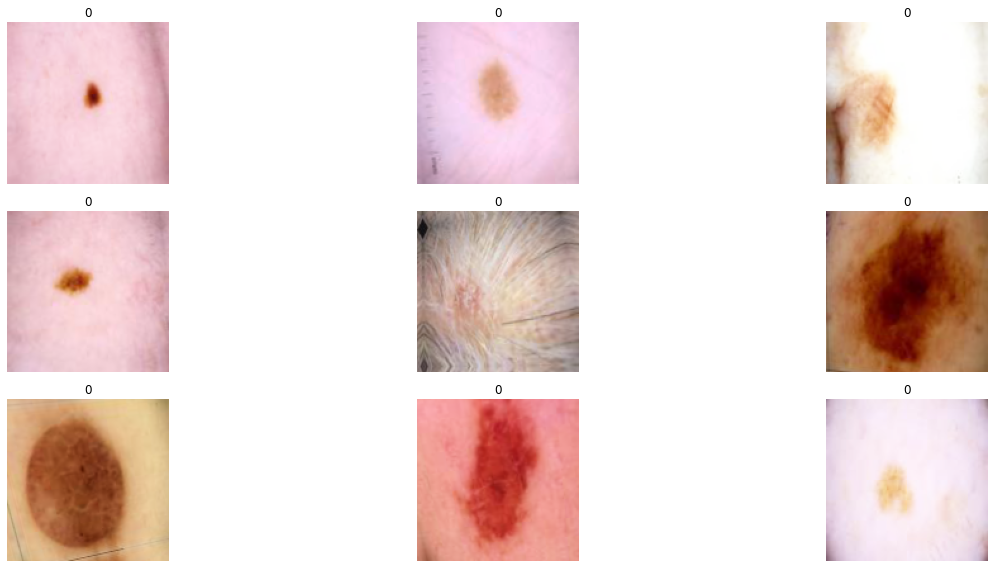

In [ ]:
img_data.show_batch(rows=3,figsize=(20,8))

In [ ]:
image_info1 = test[['image_name','patient_id']].copy()
image_df1 = image_info1.groupby(['patient_id']).agg({'image_name':'count'})
image_df1.reset_index(inplace=True)
image_df1.columns = ['patient_id','image_count']
test1 = test.merge(image_df1,on='patient_id',how='left')

In [ ]:
cat_cols = ['sex','anatom_site_general_challenge']
cont_cols = ['age_approx','image_count']

In [ ]:
from fastai.tabular import *

In [ ]:
procs = [FillMissing, Categorify, Normalize]
tab_data = (TabularList.from_df(train, path=path, cat_names=cat_cols, cont_names=cont_cols, procs=procs)
                .split_by_idx(valid_idx)
                .label_from_df(cols='target')
                .add_test(TabularList.from_df(test1, path=path, cat_names=cat_cols, cont_names=cont_cols, procs=procs,)))
              #  .databunch())

In [ ]:
data.show_batch(rows=10)

sex,anatom_site_general_challenge,age_approx_na,age_approx,image_count,target
male,lower extremity,False,1.8247,-0.9208,0
female,torso,False,0.4297,-0.8799,0
male,torso,False,0.4297,0.3473,0
female,lower extremity,False,2.8710,-0.7981,0
male,upper extremity,False,-0.9654,0.7973,0
female,torso,False,-0.2679,0.0201,0
male,lower extremity,False,1.1272,0.2655,0
male,torso,False,-0.2679,-0.6754,0
female,torso,False,-2.0117,0.2655,0
male,head/neck,False,-2.0117,0.9610,0


In [ ]:
integrate_train, integrate_valid, integrate_test = get_imagetabdatasets(img_data, tab_data)

In [ ]:
bs = 64

db = DataBunch.create(integrate_train, integrate_valid, integrate_test,
                      path=path, bs=bs)
db

DataBunch;

Train: <image_tabular.dataset.ImageTabDataset object at 0x7f2e38139128>;

Valid: <image_tabular.dataset.ImageTabDataset object at 0x7f2e38139518>;

Test: <image_tabular.dataset.ImageTabDataset object at 0x7f2e38114f28>

In [ ]:
# cnn model for images, use Resnet50 as an example
cnn_arch = models.resnet50

# cnn_out_sz is the output size of the cnn model that will be concatenated with tabular model output
cnn_out_sz = 256

# use fastai functions to get a cnn model
image_data_db = img_data.databunch()
image_data_db.c = cnn_out_sz
cnn_learn = cnn_learner(image_data_db, cnn_arch, ps=0.2)
cnn_model = cnn_learn.model

In [ ]:
# get embedding sizes of categorical data
emb_szs = tab_data.train.get_emb_szs()

# output size of the tabular model that will be concatenated with cnn model output
tab_out_sz = 8

# use fastai functions to get a tabular model
tabular_model = TabularModel(emb_szs, len(cont_cols), out_sz=tab_out_sz, layers=[8], ps=0.2)
tabular_model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(10, 6)
    (2): Embedding(3, 3)
    (3): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=17, out_features=8, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=8, out_features=8, bias=True)
  )
)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# get an integrated model that combines the two components and concatenate their outputs
# which will pass through additional fully connected layers
integrate_model = CNNTabularModel(cnn_model,
                                  tabular_model,
                                  layers = [cnn_out_sz + tab_out_sz, 32],
                                  ps=0.2,
                                  out_sz=2).to(device)

In [ ]:
# adjust loss function weight because the dataset is extremely unbalanced
weights = [1/(1-train["target"].mean()), 1/train["target"].mean()]
loss_func = CrossEntropyFlat(weight=torch.FloatTensor(weights).to(device))

In [ ]:
learn = Learner(db, integrate_model, metrics=[accuracy, ROCAUC(),AUROC()], loss_func=loss_func)

In [ ]:
learn.layer_groups = [nn.Sequential(*flatten_model(cnn_learn.layer_groups[0])),
                      nn.Sequential(*flatten_model(cnn_learn.layer_groups[1])),
                      nn.Sequential(*(flatten_model(cnn_learn.layer_groups[2]) +
                                      flatten_model(integrate_model.tabular_model) +
                                      flatten_model(integrate_model.layers)))]

epoch,train_loss,valid_loss,accuracy,rocauc,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


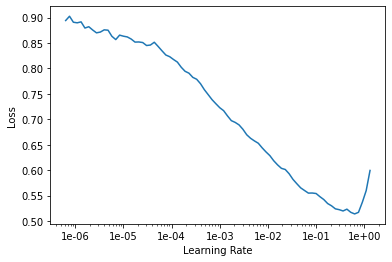

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
import gc
gc.collect()

7511

In [ ]:
from fastai.callbacks import SaveModelCallback

In [ ]:
callbacks = SaveModelCallback(learn, every='improvement', monitor='auroc', name='best_model')

In [ ]:
learn.fit_one_cycle(10 , slice(1e-1),callbacks = [callbacks])

epoch,train_loss,valid_loss,accuracy,rocauc,auroc,time
0,0.202206,0.161004,0.946208,0.982566,0.982566,05:58
1,0.250531,0.194515,0.963209,0.974679,0.974679,06:02
2,0.216553,0.155670,0.952716,0.982658,0.982658,06:02


Better model found at epoch 0 with auroc value: 0.9825658202171326.
Better model found at epoch 2 with auroc value: 0.9826578497886658.
